In [211]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt  
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve # ROC a diferencia del accuracy te da un valor justo de precision para datos desbalanceados

In [212]:
df = pd.read_csv('dataset/new_data/df_freq_done.csv')

In [213]:
df['target'] = df['target'].astype(int)

In [214]:
df.dtypes

target        int64
0_HE3       float64
1_HE3       float64
2_HE3       float64
3_HE3       float64
             ...   
4090_HE3    float64
4091_HE3    float64
4092_HE3    float64
4093_HE3    float64
4094_HE3    float64
Length: 4096, dtype: object

In [215]:
df.head()

,target,0_HE3,1_HE3,2_HE3,3_HE3,4_HE3,5_HE3,6_HE3,7_HE3,8_HE3,...,4085_HE3,4086_HE3,4087_HE3,4088_HE3,4089_HE3,4090_HE3,4091_HE3,4092_HE3,4093_HE3,4094_HE3
0,1,0.018970,0.001095,0.001061,0.001539,0.000536,0.000401,0.000258,0.000753,0.000873,...,0.000122,0.000132,0.000311,0.000170,0.000242,0.000046,0.000166,0.000136,0.000124,0.000226
1,1,0.096649,0.002541,0.000904,0.000214,0.000830,0.000382,0.000969,0.000542,0.000974,...,0.000846,0.000761,0.000471,0.000286,0.000355,0.000781,0.000580,0.000717,0.000266,0.000606
2,1,0.030549,0.001100,0.001033,0.000455,0.000489,0.000330,0.000448,0.000284,0.000363,...,0.000215,0.000316,0.000163,0.000253,0.000200,0.000364,0.000333,0.000202,0.000373,0.000174
3,1,0.060288,0.001842,0.000554,0.000437,0.000636,0.000214,0.000661,0.000875,0.000901,...,0.000208,0.000671,0.000537,0.000307,0.000077,0.000673,0.000726,0.000581,0.000491,0.000779
4,1,0.044945,0.001578,0.001163,0.000463,0.000499,0.000682,0.000298,0.000280,0.000310,...,0.000089,0.000156,0.000395,0.000641,0.000265,0.000080,0.000139,0.000076,0.000158,0.000084


In [216]:
df_as = pd.concat([df,df,df,df,df,df,df,df,df,df,df,df,df,df,df,df,df,df,df],axis=0)

In [232]:
df_as.shape

(1938, 4096)

In [218]:
df.loc[0,df.columns[1:]].tolist()

[0.0189695886230468,
 0.001095491573066,
 0.0010607258853388,
 0.0015393289778506,
 0.0005357616774402,
 0.0004006614540736,
 0.000257819253757,
 0.0007527311765993,
 0.0008725020579733,
 0.0008145523339773,
 0.0011664017452809,
 0.001827678665953,
 0.0007777195328065,
 0.000569577806715,
 0.0002699608376054,
 0.0005239582204468,
 0.0003093989436205,
 0.0007193257065935,
 0.0009176890795744,
 0.0009276685640204,
 0.0006485670444977,
 0.0017295871647149,
 0.0003170597629539,
 0.0008091761736717,
 0.0002473865408764,
 0.000693541186401,
 1.6596626006681515e-05,
 0.0001851829867915,
 0.0004354608532088,
 0.0003236294646068,
 0.0004245706192719,
 0.0010738714539006,
 0.0014549894636551,
 0.0001687616001248,
 0.0001785303901887,
 0.0002590438155291,
 0.0005904794758602,
 0.0002100086524955,
 0.0005868168544735,
 0.0005742895168938,
 0.0003690025382618,
 0.0003391146068027,
 0.0008466626971185,
 0.0009295537403939,
 0.000154903092397,
 0.0002920637850767,
 0.0001641452441582,
 0.000111189097

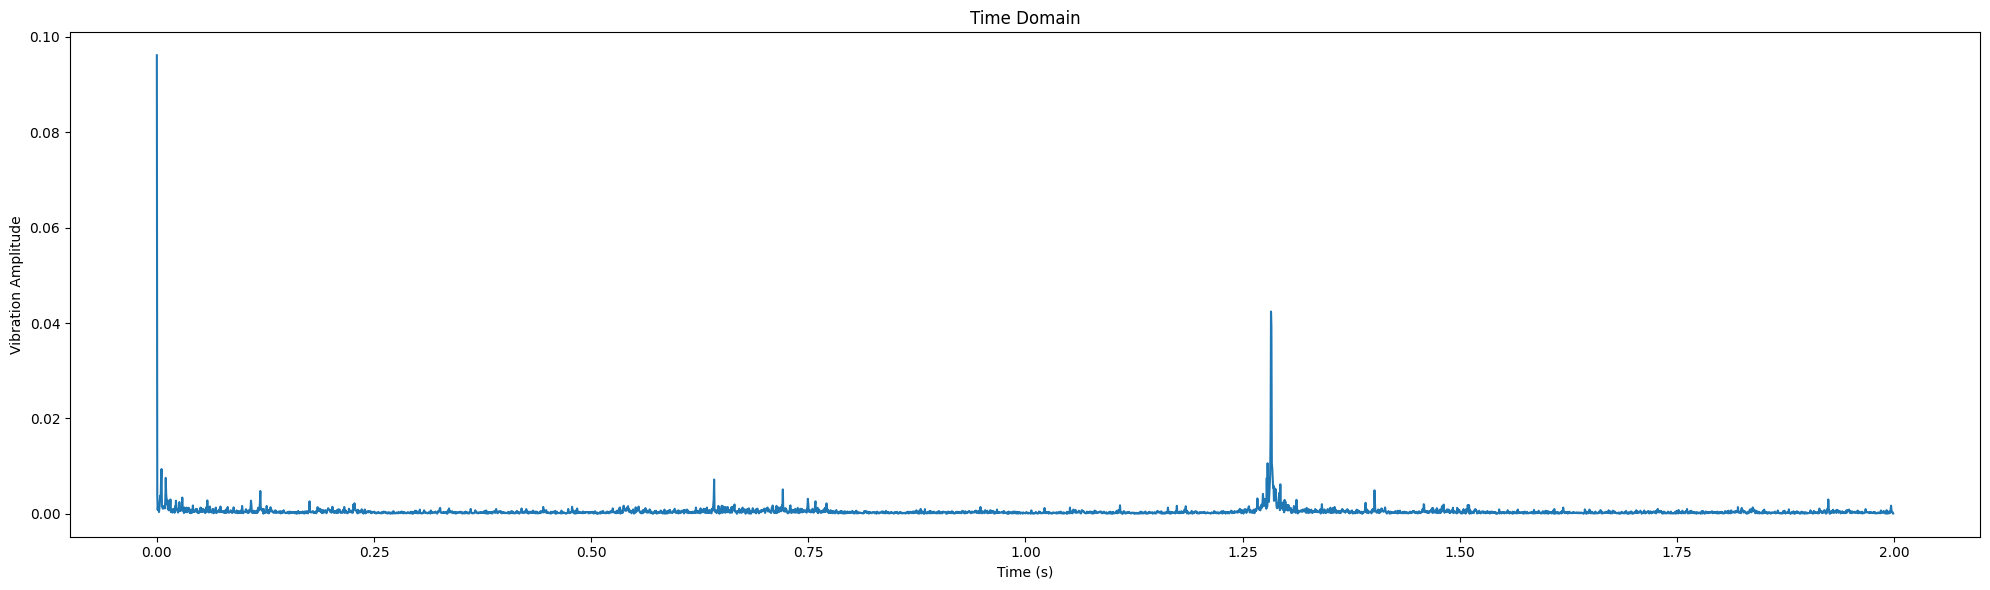

In [219]:
# Load your vibration data from a CSV file
# Assume the CSV file has a single column of vibration data with a header
# data = pd.read_csv('vibration_data.csv')

y = np.array(df.loc[6,df.columns[1:]].tolist())
# vibration_data = data['Vibration'].values
vibration_data = y
# Time parameters
sampling_rate = 2048  # Hz, example sampling rate
n = len(vibration_data)
time = np.arange(n) / sampling_rate

# Perform FFT
freq_domain = np.fft.fft(vibration_data)
freq = np.fft.fftfreq(n, d=1/sampling_rate)

x_freq = freq[:n//2]
y_freq = np.abs(freq_domain)[:n//2] * 1/n


# Plot the results
plt.figure(figsize=(20,6))

plt.plot(time, vibration_data)
plt.title('Time Domain')
plt.xlabel('Time (s)')
plt.ylabel('Vibration Amplitude')


plt.tight_layout()
plt.show()

In [220]:
X = df_as.drop("target", axis=1) 
y = df_as["target"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [231]:
X.describe()

,0_HE3,1_HE3,2_HE3,3_HE3,4_HE3,5_HE3,6_HE3,7_HE3,8_HE3,9_HE3,...,4085_HE3,4086_HE3,4087_HE3,4088_HE3,4089_HE3,4090_HE3,4091_HE3,4092_HE3,4093_HE3,4094_HE3
count,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,...,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000
mean,0.053892,0.002640,0.001789,0.001519,0.001038,0.001044,0.001418,0.001336,0.001393,0.002032,...,0.000322,0.000337,0.000313,0.000366,0.000369,0.000397,0.000430,0.000387,0.000412,0.000351
std,0.023616,0.003188,0.002862,0.001309,0.001142,0.001618,0.001875,0.001190,0.001524,0.002025,...,0.000286,0.000341,0.000256,0.000318,0.000400,0.000470,0.000495,0.000420,0.000487,0.000296
min,0.015243,0.000257,0.000148,0.000123,0.000055,0.000068,0.000126,0.000112,0.000089,0.000023,...,0.000024,0.000027,0.000030,0.000024,0.000027,0.000036,0.000011,0.000011,0.000017,0.000026
25%,0.037118,0.001141,0.000829,0.000754,0.000489,0.000443,0.000540,0.000542,0.000592,0.000880,...,0.000145,0.000158,0.000134,0.000176,0.000170,0.000158,0.000191,0.000176,0.000187,0.000152
50%,0.049535,0.001979,0.001442,0.001167,0.000786,0.000721,0.000989,0.000969,0.001070,0.001599,...,0.000235,0.000251,0.000258,0.000277,0.000266,0.000276,0.000333,0.000282,0.000306,0.000280
75%,0.066617,0.003088,0.002023,0.001996,0.001252,0.001210,0.001659,0.002015,0.001821,0.002723,...,0.000394,0.000402,0.000398,0.000444,0.000446,0.000406,0.000504,0.000410,0.000433,0.000411
max,0.140399,0.029831,0.029123,0.011265,0.010337,0.016040,0.017074,0.008007,0.014215,0.016834,...,0.001604,0.002533,0.001433,0.001764,0.002760,0.003760,0.004404,0.003252,0.004078,0.001860


In [221]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1356, 4095)
(582, 4095)
(1356,)
(582,)


In [222]:
pd.DataFrame(y_train).groupby('target').agg({'target':['count']})

,target
,count
target,
0,658
1,698


In [223]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Assuming X is your features matrix and y is the target vector
model = LogisticRegression()
model.fit(X, y)

importance = np.abs(model.coef_[0])
print(importance)


[7.02949251 0.29519293 0.04507899 ... 0.06723756 0.06141131 0.03088344]


In [224]:
def apply_classifier(clf,xTrain,xTest,yTrain,yTest):

    clf.fit(xTrain, yTrain) #Entrenamiento del modelo
    predictions = clf.predict(xTest) #Validación sobre la data de testing
    conf_mtx = confusion_matrix(yTest,predictions) #Matriz de confusión de la data de testing real con la predicha

    f, axes = plt.subplots(ncols=2, figsize=(15, 5)) #Definición del área de visualización (2 gráficas)

    sns.heatmap(conf_mtx,annot=True,cbar = False,fmt = "g",ax = axes[0])#definición del formato de la matriz de confusión
    axes[0].set_xlabel('Predicted labels') #Titulo del eje x de la matriz de confusión
    axes[0].set_ylabel('True labels') #Titulo del eje y de la matriz de confusión
    axes[0].set_title('Confusion Matrix Test'); #Titulo de la matriz de confusión
    axes[0].xaxis.set_ticklabels(['Not Fault', 'Fault']); #distribución de los resultados en la matriz de confusión del eje x
    axes[0].yaxis.set_ticklabels(['Not Fault', 'Fault']); #distribución de los resultados en la matriz de confusión del eje y

    print(classification_report(yTest,predictions)) #mostrar resultados

    roc_auc = roc_auc_score(yTest,predictions) #definición del cálculo del auc
    print ("AUC ROC : ",roc_auc) #mostrar el resultado

    fpr, tpr,_ = roc_curve(yTest, predictions) #Función para armar la curva ROC
    #fpr : false positive rate
    #tpr : true positive rate
    axes[1].plot(fpr,tpr,label= "auc="+str(roc_auc)); #código para mostrar el resultado del auc en la gráfica
    axes[1].plot([0, 1], [0, 1]) #código del formato de la gráfica
    plt.xlabel('False Positive Rate') #título del eje x
    plt.ylabel('True Positive Rate') #título del eje y
    plt.title('ROC') #título del gráfico

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       311
           1       1.00      1.00      1.00       271

    accuracy                           1.00       582
   macro avg       1.00      1.00      1.00       582
weighted avg       1.00      1.00      1.00       582

AUC ROC :  1.0


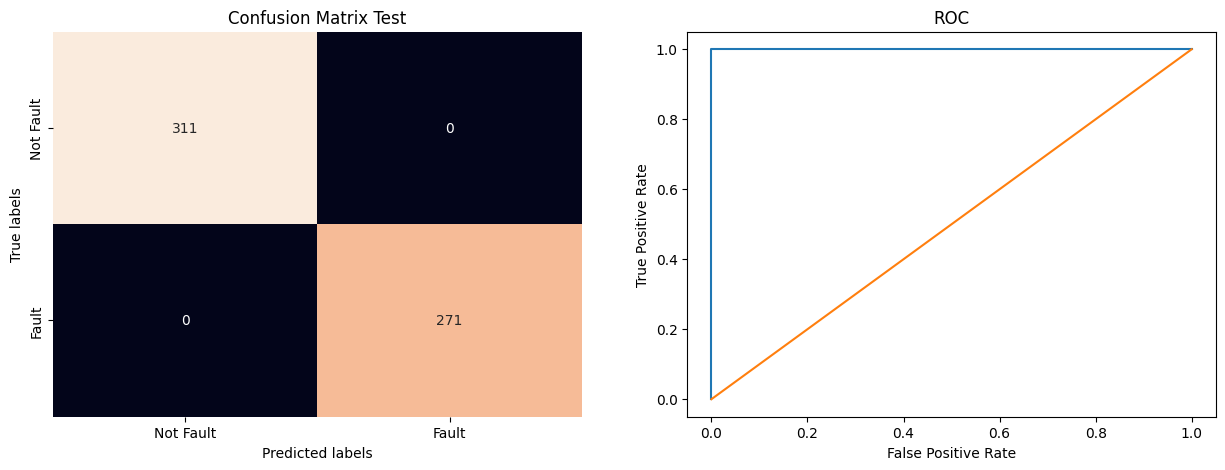

In [225]:
decision_tree = DecisionTreeClassifier() # Definir nuestro modelo
apply_classifier(decision_tree,X_train, X_test, y_train, y_test) # Aplicar la funcion que hemos construido

              precision    recall  f1-score   support

           0       0.98      0.79      0.88       311
           1       0.81      0.98      0.88       271

    accuracy                           0.88       582
   macro avg       0.89      0.89      0.88       582
weighted avg       0.90      0.88      0.88       582

AUC ROC :  0.8860359986236518


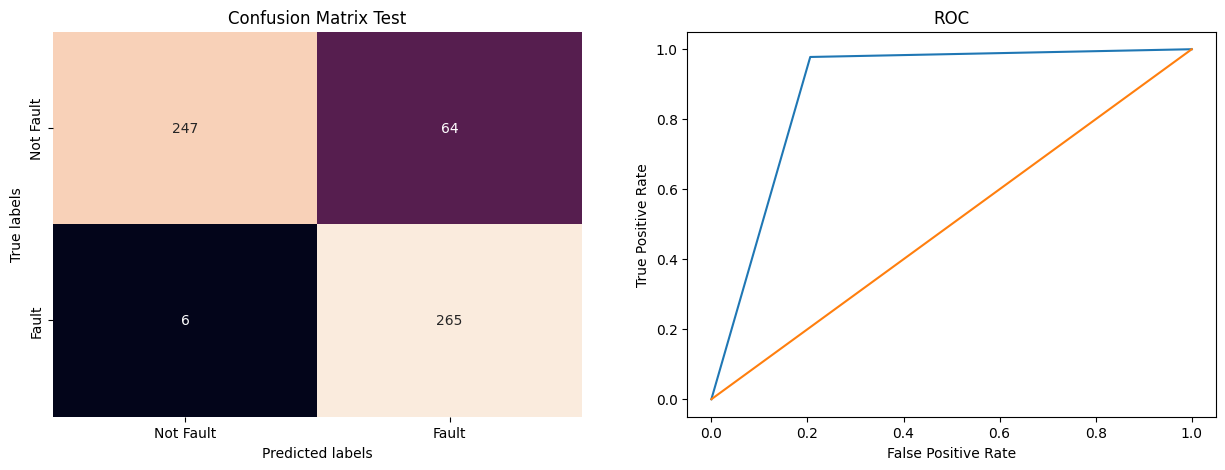

In [226]:
logistic_reg = LogisticRegression()
apply_classifier(logistic_reg,X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       311
           1       1.00      1.00      1.00       271

    accuracy                           1.00       582
   macro avg       1.00      1.00      1.00       582
weighted avg       1.00      1.00      1.00       582

AUC ROC :  1.0


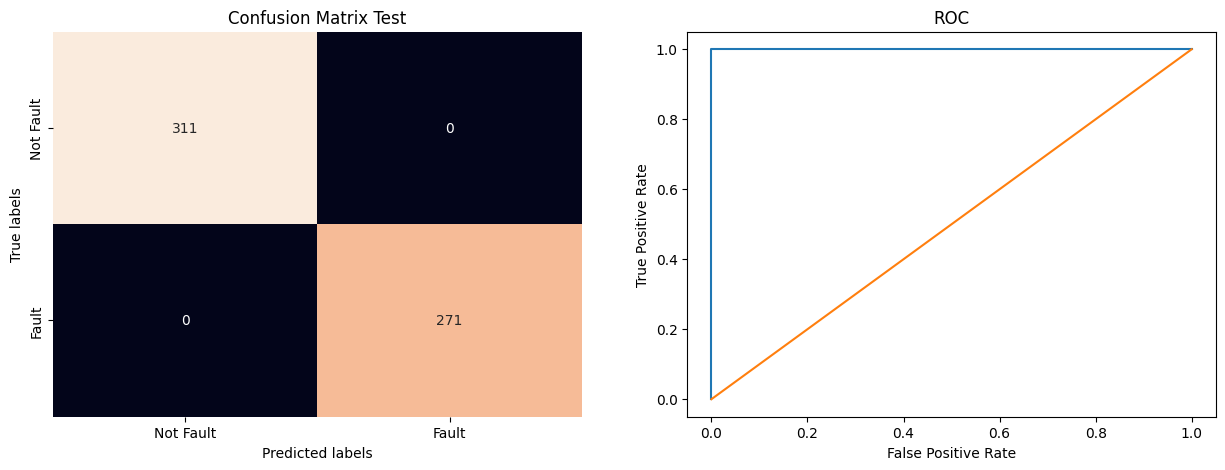

In [227]:
random_forest = RandomForestClassifier(random_state = 42)
apply_classifier(random_forest,X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       311
           1       1.00      1.00      1.00       271

    accuracy                           1.00       582
   macro avg       1.00      1.00      1.00       582
weighted avg       1.00      1.00      1.00       582

AUC ROC :  1.0


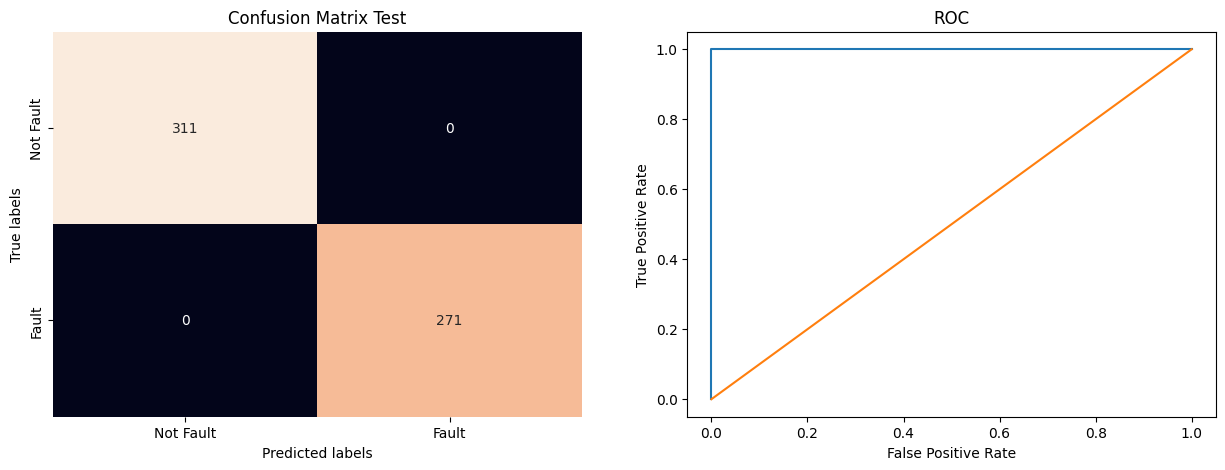

In [228]:
xg_boost = XGBClassifier()
apply_classifier(xg_boost,X_train, X_test, y_train, y_test)

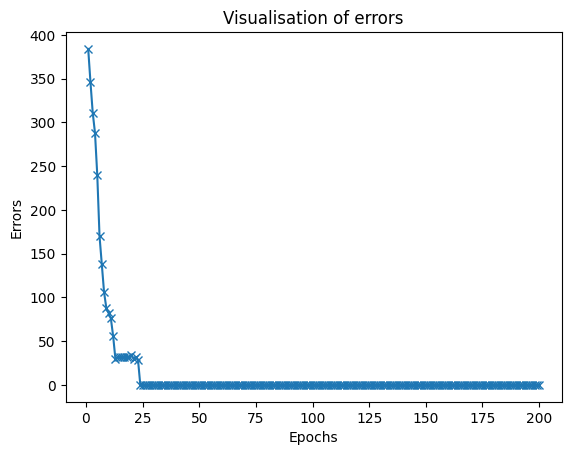

In [229]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


class Perceptron(object):
    """ Perceptron for demonstrating a binary classifier """

    def __init__(self, learn_rate = 0.01, iterations = 100):
        self.learn_rate = learn_rate
        self.iterations = iterations


    def fit(self, X, y, biased_X = True):
        """ Fit training data to our model """
        X = self._add_bias(X)
        self._initialise_weights(X)

        self.errors = []

        for cycle in range(self.iterations):
            trg_error = 0
            for x_i, output in zip(X, y):
                output_pred = self.predict(x_i, biased_X=True)
                trg_update = self.learn_rate * (output - output_pred)
                self.weights += trg_update * x_i
                trg_error += int(trg_update != 0.0)
            self.errors.append(trg_error)

        return self


    def _net_input(self, X):
        """ Net input function (weighted sum) """
        """ print(self.weights)  """
        return np.dot(X, self.weights)


    def predict(self, X, biased_X=False):
        """ Make predictions for the given data, X, using unit step function """
        if not biased_X:
            X = self._add_bias(X)
        return np.where(self._net_input(X) >= 0.0, 1, 0)


    def _add_bias(self, X):
        """ Add a bias column of 1's to our data, X """
        bias = np.ones((X.shape[0], 1))
        biased_X = np.hstack((bias, X))
        return biased_X


    def _initialise_weights(self, X):
        """ Initialise weigths - normal distribution sample with standard dev 0.01 """
        random_gen = np.random.RandomState(1)
        self.weights = random_gen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        return self


# create a perceptron classifier and train on our data
classifier = Perceptron(learn_rate = 0.001, iterations = 200)
classifier.fit(X_train, y_train)

# plot our misclassification error after each iteration of training
plt.plot(range(1, len(classifier.errors) + 1), classifier.errors, marker = 'x')
plt.title("Visualisation of errors")
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.show()

c:\Users\kainak0\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


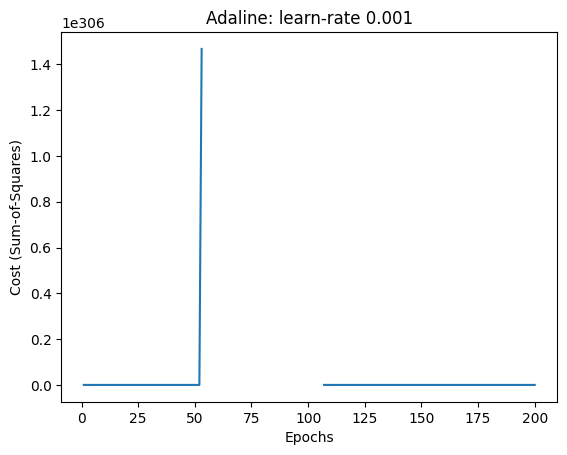

In [230]:
class Adaline(object):
    """ Adaline (Adaptive Linear Neuron) for binary classification.
        Minimises the cost function using gradient descent. """

    def __init__(self, learn_rate = 0.01, iterations = 100):
        self.learn_rate = learn_rate
        self.iterations = iterations


    def fit(self, X, y, biased_X = False, standardised_X = False):
        """ Fit training data to our model """
        if not standardised_X:
            X = self._standardise_features(X)
        if not biased_X:
            X = self._add_bias(X)
        self._initialise_weights(X)
        self.cost = []

        for cycle in range(self.iterations):
            output_pred = self._activation(self._net_input(X))
            errors = y - output_pred
            self.weights += (self.learn_rate * X.T.dot(errors))
            cost = (errors**2).sum() / 2.0
            self.cost.append(cost)
        return self


    def _net_input(self, X):
        """ Net input function (weighted sum) """
        return np.dot(X, self.weights)


    def predict(self, X, biased_X=False):
        """ Make predictions for the given data, X, using unit step function """
        if not biased_X:
            X = self._add_bias(X)
        return np.where(self._activation(self._net_input(X)) >= 0.0, 1, 0)


    def _add_bias(self, X):
        """ Add a bias column of 1's to our data, X """
        bias = np.ones((X.shape[0], 1))
        biased_X = np.hstack((bias, X))
        return biased_X


    def _initialise_weights(self, X):
        """ Initialise weigths - normal distribution sample with standard dev 0.01 """
        random_gen = np.random.RandomState(1)
        self.weights = random_gen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        return self


    def _standardise_features(self, X):
        """ Standardise our input features with zero mean and standard dev of 1 """
        X_norm = (X - np.mean(X, axis=0)) / np.std(X, axis = 0)
        return X_norm


    def _activation(self, X):
        """ Linear activation function - simply returns X """
        return X


# create a perceptron classifier and train on our data
classifier = Adaline(learn_rate = 0.001, iterations = 200)
classifier.fit(X_train, y_train)

# plot our misclassification error after each iteration of training
plt.plot(range(1, len(classifier.cost) + 1), classifier.cost)
plt.title("Adaline: learn-rate 0.001")
plt.xlabel('Epochs')
plt.ylabel('Cost (Sum-of-Squares)')
plt.show()